In [2]:
import csv
import numpy as np
import ROOT as rt
from glob import glob
donotdelete = []
import math

Welcome to JupyROOT 6.13/02


In [3]:
# f = open('../data/181018_wrapping_test_SensLJ/Laser_12x12x4_SensLJ_OV30p0_Tune89_OptFilternd1.csv')
#f = open('../data/181017_HPK/HPK_57V_SinglePhoton_NoExtAmp_F1Board.csv')
# f = open('../data/18_10_24_sensL_J33_singlephoton/J_33_5/Laser_tune90_ND1_singlephoton_SL_J33_5_OV30V_NoExtAmp.csv')
# f = open('../data/18_10_24_sensL_J33_singlephoton/J_33_4/Laser_tune92p5_ND1_singlephoton_SL_J33_3_OV30V_miniAmp.csv')
#f = open('../data/18_10_24_sensL_J33_singlephoton/J_33_3/Laser_tune90_ND1_singlephoton_SL_J33_3_OV30V_NoExtAmp.csv')
# f = open('../data/18_10_24_sensL_J33_singlephoton/J_33_3/Laser_tune92p5_ND1_singlephoton_SL_J33_3_OV26p5V_miniAmp.csv')
# f = open('../data/18_10_26_gain_gate_test_Ham_laser/Laser92_ND1_ham_test_gain_6ns_gate_window_v2.csv')
# f = open('../data/18_10_26_single_photon_sensL_ham_noextamp_gain_measurement_optimal_gate/laser_tune_95p6_J_33_serial2_gain_15ns_gate.csv')
# f = open('../data/18_10_30_sinlge_pe_new_amps_Laser90_ND1/Laser90_ND1_SensL_J33_4_Amp74+_gate_15ns_OV30V.csv')
# f = open('../data/181101_sensL_C_33_20_gate_test/Laser85_ND1_sensL_C_33_20_1_gate_10ns_OV30V.csv')
# f = open('../data/181101_laser95_nd1_V_bd_measurement_SensL_C_33_20/laser92_nd1_Sensl_C_33_20_1_OV27V_miniAmp.csv')
# f = open('../data/18_10_29_HamSurfaceMount_SinglePhoton/Laser90_ND1_Ham_OV57V_miniAmp_gate4ns.csv')
# f = open('../data/18_11_05_single_photon_sensl_boards/J_44_35_2/sensl_J_44_35_2_LaserTune90_ND1_OV30V_NoExtAmp_gate15ns.csv')

f = open('../data/190523_doe_visit/SenslJ33_4_SinglePhoton.csv')


content = csv.reader(f)
amp_factor = 10
Resistance = 50
Amp_x_R = amp_factor * Resistance
negative_pulse = False

x = []
y = []
if negative_pulse:
    for r in content:
        x.append(1.0*1e12*float(r[0]) / Amp_x_R) # x has unit pC now
    #     x.append(float(r[0]))
        y.append(float(r[1]))
        
#     print(x[-1],x[0])
    x0 = x[0]
    x1 = x[-1]
else:
    for r in content:
        x.append(-1.0*1e12*float(r[0]) / Amp_x_R) # x has unit pC now
        y.append(float(r[1]))
    x0 = x[-1]
    x1 = x[0]
    y.reverse()


In [4]:
if negative_pulse:
    h = rt.TH1F('h', 'h', int(len(x)), x[0], x[-1])
else:
    h = rt.TH1F('h', 'h', int(len(x)), x[-1], x[0])
h.SetXTitle('Charge [pC]')
h.SetYTitle('Events / {:1.1e} pC'.format(h.GetBinWidth(1)))
for i in range(len(x)):
    h.SetBinContent(i+1, y[i])
    
    

In [5]:
peak_sigma = 0.01
SS = rt.TSpectrum()
n_pks = SS.Search(h, 0.001, "", 0.005)
x_pos = SS.GetPositionX()
y_pos = SS.GetPositionY()
print n_pks
Ch2N = 1.0e-12/1.6e-19
print(x_pos[0])
print (x_pos[1]-x_pos[0])*Ch2N

6
-0.003557983
74420.4


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [12]:
gr_gain = rt.TGraphErrors(n_pks)


# Ch2N = 1e-12/(1.6e-19 * amp_factor * Resistance)
Ch2N = 1.0e-12/1.6e-19
# Ch2N = 1e3/(amp_factor * Resistance)
peak_height_position = []
pos_err = []

h_poiss = rt.TH1F('h_poiss', 'Measured probability of number of photo electrons', n_pks, -0.5, n_pks - 0.5)
# mean = []
# sig = []

for i in range(n_pks):
    n_pk = h.FindBin(x_pos[i])
    
    thr = 0.6* h.GetBinContent(n_pk)
    
    n_low = n_pk
    while h.GetBinContent(n_low) > thr:
        n_low -= 1
    x_low = h.GetBinCenter(n_low)    
    
        
    n_up = n_pk
    while h.GetBinContent(n_up) > thr:
        n_up += 1
    x_up = h.GetBinCenter(n_up)
    
    r = h.Fit('gaus', 'LRSQ+', '', x_low, x_up)
    print('xlow, xup',x_low,x_up)
    r = r.Get()
    print r



    print ("peak number: "+ str(i)+', prob: '+str(r.Prob()))
    
    integral = r.Parameter(0) * np.sqrt(2*np.pi) * r.Parameter(2) / h.GetBinWidth(1)
    peak_height_position.append((integral,r.Parameter(1)))
    pos_err.append(r.ParError(1))
    h_poiss.SetBinContent(i+1, integral)
    d_int = integral * rt.TMath.Hypot(r.ParError(0)/r.Parameter(0), r.ParError(2)/r.Parameter(2))
    h_poiss.SetBinError(i+1, d_int)
    print(r.Parameter(1), "pC",r.ParError(1))

# print('gain: '+str(int(gain))+', gain uncertainty: '+str(int(gain_err)))
peak_height_position.sort(key=lambda tup: tup[1])
events = h.Integral()
for i in range(len(peak_height_position)):
    gr_gain.SetPoint(int(i), float(i), peak_height_position[i][1])
    gr_gain.SetPointError(int(i), 0, pos_err[i])



('xlow, xup', -0.005418493000000003, -0.0016974729999999975)
<ROOT.TFitResult object ("TFitResult-h-gaus") at 0x7fef386c9980>
peak number: 0, prob: 0.392387024375
(-0.003456606431948036, 'pC', 1.8017662306411734e-05)
('xlow, xup', 0.006116668999999998, 0.010209791000000003)
<ROOT.TFitResult object ("TFitResult-h-gaus") at 0x7fef3870f520>
peak number: 1, prob: 0.580843517535
(0.008106963279583304, 'pC', 2.382966204337442e-05)
('xlow, xup', 0.016907626999999988, 0.02174495299999999)
<ROOT.TFitResult object ("TFitResult-h-gaus") at 0x7fef38715890>
peak number: 2, prob: 0.0898881123405
(0.01945394080881456, 'pC', 3.463486346988492e-05)
('xlow, xup', 0.028442789000000003, 0.033280115000000006)
<ROOT.TFitResult object ("TFitResult-h-gaus") at 0x7fef3870ff60>
peak number: 3, prob: 0.428760898189
(0.030900745834621768, 'pC', 4.93971939750561e-05)
('xlow, xup', 0.040350053000000004, 0.04444317500000001)
<ROOT.TFitResult object ("TFitResult-h-gaus") at 0x7fef36dcf8f0>
peak number: 4, prob: 0.979

Warning in <TROOT::Append>: Replacing existing TH1: h_poiss (Potential memory leak).


In [7]:
#### Cross talk
n = 4
# print(peak_height_position[0][0]/events,peak_height_position[1][0]/events)
mu = -np.log(peak_height_position[0][0]/events)
epsilon = 1- peak_height_position[1][0]/events/(mu*math.exp(-mu))
crosstalk = epsilon + (3*n-3)/(2*n)*epsilon**2
print epsilon,crosstalk
# print math.log(0.3218504185316469),mu

0.3051997542235939 0.39834664420173604


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_spectrum


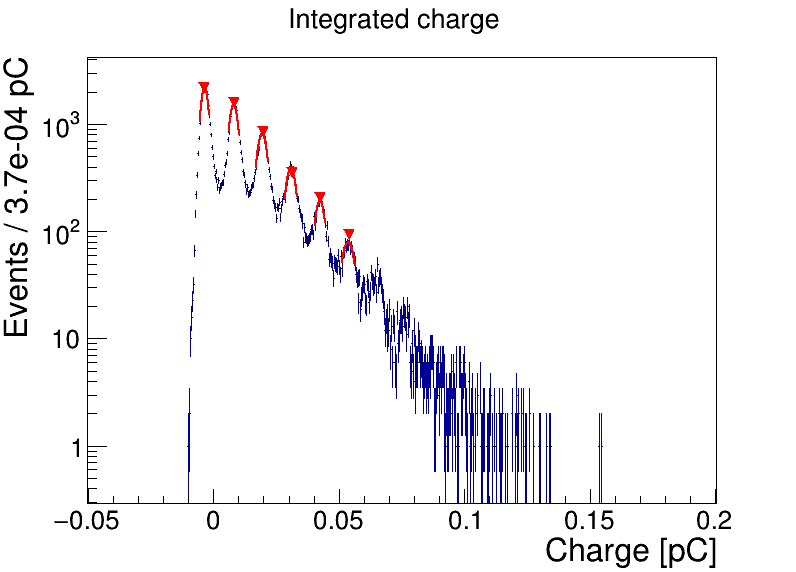

In [10]:
c = rt.TCanvas('c_spectrum', 'c_spectrum', 800, 600)
rt.gStyle.SetOptFit(000002200)
h.SetStats(0)
h.GetXaxis().SetRangeUser(-0.05,0.2)
h.SetTitle('Integrated charge')
h.GetXaxis().SetTitleSize(0.06)
h.GetXaxis().SetTitleOffset(0.9)
h.GetXaxis().SetLabelSize(0.05)

h.GetYaxis().SetTitleSize(0.06)
h.GetYaxis().SetTitleOffset(0.9)
h.GetYaxis().SetLabelSize(0.05)

c.SetLeftMargin(0.11)
c.SetBottomMargin(0.12)
h.DrawCopy('E')
c.SetLogy()
# c.SetGrid()
c.Draw()
donotdelete.append(c)

p-val = 0.002

****************************************
Minimizer is Linear
Chi2                      =      16.5241
NDf                       =            4
p0                        =  -0.00342984   +/-   1.61434e-05 
p1                        =    0.0114603   +/-   1.15228e-05 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_gain


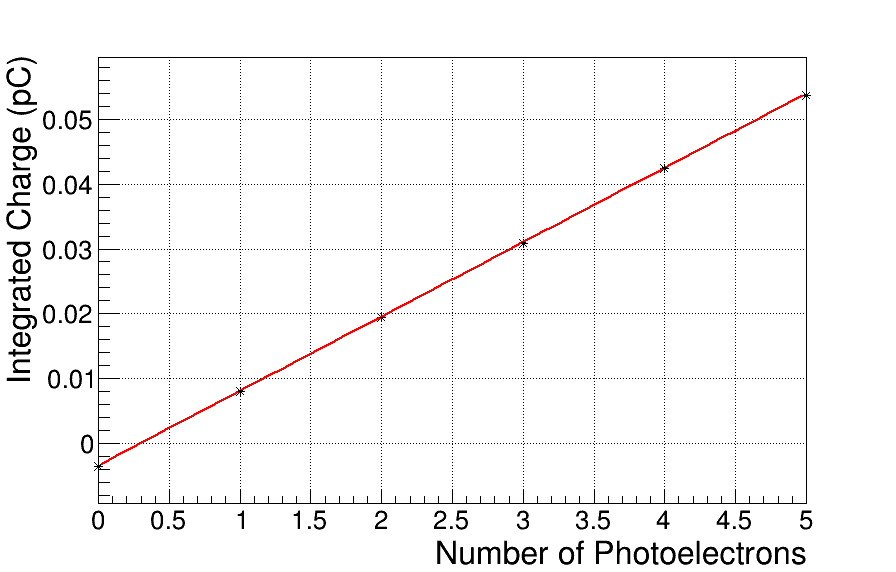

In [20]:
r = gr_gain.Fit('pol1', 'S')
r = r.Get()

print 'p-val = {:.3f}'.format(r.Prob())

c_gain = rt.TCanvas('c_gain', 'c_gain', 900, 600)
gr_gain.Draw('AP*E1')
gr_gain.SetTitle("")
gr_gain.GetXaxis().SetTitle('Number of Photoelectrons')
gr_gain.GetYaxis().SetTitle('Integrated Charge (pC)')
gr_gain.GetYaxis().SetLimits(0,0.06)
gr_gain.GetXaxis().SetLimits(0,5)


gr_gain.GetXaxis().SetTitleSize(0.06)
gr_gain.GetXaxis().SetTitleOffset(0.9)
gr_gain.GetXaxis().SetLabelSize(0.05)

gr_gain.GetYaxis().SetTitleSize(0.06)
gr_gain.GetYaxis().SetTitleOffset(0.9)
gr_gain.GetYaxis().SetLabelSize(0.05)

c_gain.SetLeftMargin(0.11)
c_gain.SetBottomMargin(0.12)

c_gain.SetGrid()
c_gain.Draw()

rt.gStyle.SetOptFit(0)



 FCN=0.0338454 FROM MINOS     STATUS=SUCCESSFUL     68 CALLS         407 TOTAL
                     EDM=2.24459e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00146e+00   1.00149e+00   2.90953e-06  -2.99256e-07
   2  p1           1.20456e+00   1.11457e+00   1.11457e+00  -1.11829e-07
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_poiss


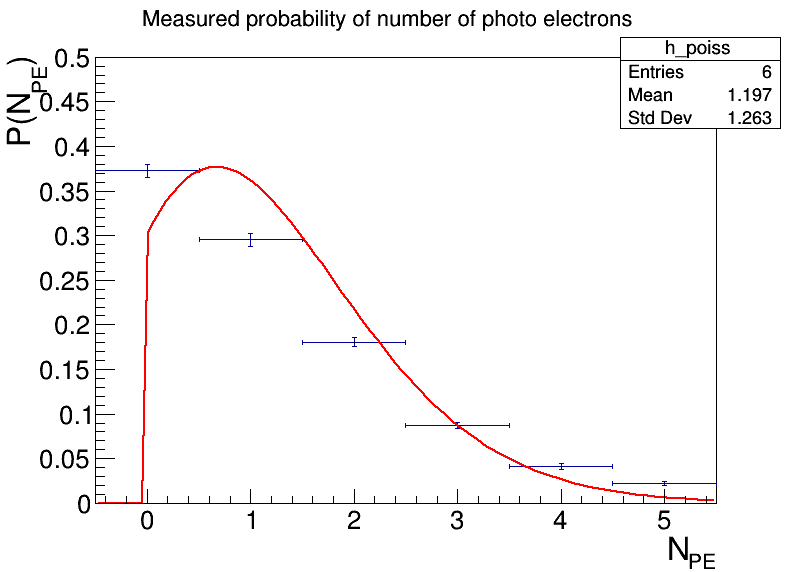

In [22]:
h_poiss.Scale(1./h_poiss.Integral())
h_poiss.SetXTitle('N_{PE}')
h_poiss.SetYTitle('P(N_{PE})')
h_poiss.SetStats(1)
c_poiss = rt.TCanvas('c_poiss', 'c_poiss', 800, 600)


poiss = rt.TF1('f_poiss', '[0]*TMath::Poisson(x,[1])')
r = h_poiss.Fit('f_poiss', 'LSE')

h_poiss.GetXaxis().SetTitleSize(0.06)
h_poiss.GetXaxis().SetTitleOffset(0.9)
h_poiss.GetXaxis().SetLabelSize(0.05)

h_poiss.GetYaxis().SetTitleSize(0.06)
h_poiss.GetYaxis().SetTitleOffset(0.9)
h_poiss.GetYaxis().SetLabelSize(0.05)

c_poiss.SetLeftMargin(0.12)
c_poiss.SetBottomMargin(0.12)



h_poiss.Draw('E1')

# rt.gStyle.SetOptFit(0)


h_poiss.GetYaxis().SetRangeUser(0., 0.5)
# c_poiss.SetLogy()
c_poiss.Draw()
